[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/idealo/image-super-resolution/blob/master/notebooks/ISR_Prediction_Tutorial.ipynb)

# Install ISR

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install tensorflow_core
!pip install ISR==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ISR-2.2.0-py3-none-any.whl (33 kB)
  Using cached ISR-2.1.1-py3-none-any.whl (32 kB)
  Using cached ISR-2.1-py3-none-any.whl (32 kB)


# Predict

Download a sample image

In [ ]:
!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
!mkdir -p data/input/test_images
!mv *.png data/input/test_images

--2022-11-30 20:39:06--  http://images.math.cnrs.fr/IMG/png/section8-image.png
Resolving images.math.cnrs.fr (images.math.cnrs.fr)... 134.206.83.12
Connecting to images.math.cnrs.fr (images.math.cnrs.fr)|134.206.83.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114590 (112K) [image/png]
Saving to: ‘section8-image.png’

section8-image.png  100%[===================>] 111.90K   145KB/s    in 0.8s    

2022-11-30 20:39:08 (145 KB/s) - ‘section8-image.png’ saved [114590/114590]



Load the image with PIL

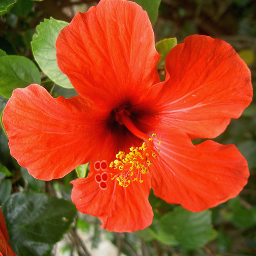

In [ ]:
import numpy as np
from PIL import Image

img = Image.open('data/input/test_images/section8-image.png')
# img = Image.open('path/to/your/image.png')
img

## Get predictions

### Create the model and run prediction
Create a RDN model with the provided pre-trained weights

In [ ]:
from ISR.models import RRDN

model = RRDN(weights='gans')

ModuleNotFoundError: ignored

#### Baseline

Bicubic upscaling

In [ ]:
bicubic = img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)

RDN

In [ ]:
img = img.convert("RGB")
sr_img = model.predict(np.array(img))
Image.fromarray(sr_img)

### Artifact elimination
Use rotation and averaging to remove upscaling artifacts

In [ ]:
from tensorflow_core import data
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
import numpy
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

img = img.convert("RGB")
sr_img = model.predict(np.array(img))

bicubic = img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)
resample = img.resize((img.size[0]*4, img.size[1]*4))
sr = cv2.cvtColor(numpy.array(sr_img), cv2.COLOR_RGB2BGR)
input = cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)

outputs = []

top = math.ceil(abs(input.shape[0] * math.sin(45)) + abs(input.shape[1] * math.cos(45)) - input.shape[0])
side = math.ceil(abs(input.shape[0] * math.cos(45)) + abs(input.shape[1] * math.sin(45)) - input.shape[1])

sr_border = cv2.copyMakeBorder(input, top, top, side, side, cv2.BORDER_CONSTANT, value=[0,0,0])

for angle in [0, 10, 30, 45]:
  print(f"Upscaling at {angle} degrees... ", end='')


  rotated = imutils.rotate(sr_border, angle)

  sr_rot = np.array(model.predict(rotated))

  sr_new = imutils.rotate(sr_rot, -1*angle)
  cropW = (sr_new.shape[1]-sr.shape[1])//2;
  cropH = (sr_new.shape[0]-sr.shape[0])//2;
  sr_new = sr_new[cropH:(sr_new.shape[0]-cropH), cropW:(sr_new.shape[1]-cropW)]
  print("[DONE]")
  
  assert sr_new.shape == sr.shape, f"Expected output of shape {sr.shape} but got output of shape {sr_new.shape}"
  outputs.append(sr_new)

print("Bicubic upscale:")
cv2_imshow( cv2.cvtColor( numpy.array( img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)), cv2.COLOR_RGB2BGR) )

print("Improved RDN upscale:")
sr_new = np.average(outputs, axis=0)
cv2_imshow(sr_new)

